In [1]:
import pandas as pd
import seaborn as sns
import sqlite3
conn = sqlite3.connect('Northwind_small.sqlite')
cur = conn.cursor()

In [25]:
cur.execute("""select discount, quantity, productid
               from orderdetail
               order by 1""")
df = pd.DataFrame(cur.fetchall(), columns=['discount','quantity','productid'])
df

,discount,quantity,productid
0,0.00,12,11
1,0.00,10,42
2,0.00,5,72
3,0.00,9,14
4,0.00,40,51
...,...,...,...
2150,0.25,4,30
2151,0.25,20,54
2152,0.25,20,6
2153,0.25,20,14


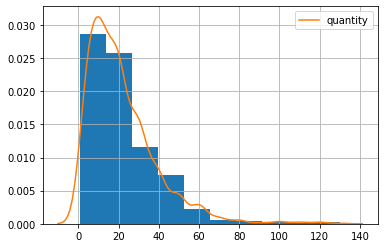

In [26]:
df_0 = df[df['discount'] == 0.]
df_0['quantity'].hist(density=True);
sns.kdeplot(df_0['quantity'])

In [27]:
for i in list(df['discount'].unique()):
    print(i, len(df[df['discount'] == i]))

0.0 1317
0.01 1
0.02 2
0.03 3
0.04 1
0.05 185
0.06 1
0.1 173
0.15 157
0.2 161
0.25 154


The action plan now is to keep discount 0, 0.05, 0.1, 0.15, 0.2, and 0.25 and toss out the other ones. we can run tukey range test to see which discounts are statistically significantly different from discount 0. also look into names of products to check for similarity. perhaps the more expensive version of a similar product would be made more attractive by a robust discount.

In [28]:
cur.execute("""select distinct productname from product""")
df_products = pd.DataFrame(cur.fetchall())
df_products

,0
0,Chai
1,Chang
2,Aniseed Syrup
3,Chef Anton's Cajun Seasoning
4,Chef Anton's Gumbo Mix
...,...
72,Röd Kaviar
73,Longlife Tofu
74,Rhönbräu Klosterbier
75,Lakkalikööri


In [29]:
df['productid'].unique()

array([11, 42, 72, 14, 51, 41, 65, 60, 31, 39, 49, 74,  2, 16, 36, 59, 53,
       77, 27, 21, 37, 57, 35,  7, 56, 24, 17, 70, 40, 29, 43, 33, 20, 71,
       10, 13, 28, 62, 44, 63, 73, 55, 75, 19, 30, 15, 34,  3, 64,  5, 18,
        1, 69, 66, 68, 54,  4,  6, 76, 52, 25, 46, 23, 26,  8, 38, 58, 50,
       47, 61, 22, 12, 45, 67,  9, 48, 32], dtype=int64)

In [30]:
len(df['orderid'].unique())

KeyError: 'orderid'

<BarContainer object of 1 artists>

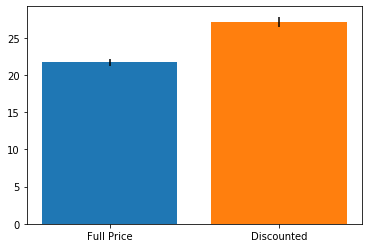

In [31]:
#first show evidence of impact on quantity

import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt

df['discounted'] = np.where(df['discount']==0.00,0,1)
df.head()
grp0 = df.groupby('discounted').get_group(0)['quantity']
grp1 = df.groupby('discounted').get_group(1)['quantity']

plt.bar(x='Full Price', height=grp0.mean(), yerr=stats.sem(grp0))

plt.bar(x='Discounted', height=grp1.mean(), yerr=stats.sem(grp1))

In [32]:
stats.normaltest(grp0), stats.normaltest(grp1)
#this shows that the distros are not normal

(NormaltestResult(statistic=544.5770045551502, pvalue=5.579637380545965e-119),
 NormaltestResult(statistic=261.5280122997891, pvalue=1.6214878452828687e-57))

In [33]:
stats.mannwhitneyu(grp0, grp1)
#note: since our sample sizes are large (>15) we can use 2-sample t-test also

MannwhitneyuResult(statistic=461541.0, pvalue=6.629381826999866e-11)

In [66]:
#now we need to know which discounts are significantly different
import statsmodels.api as sms
data = df['quantity'].values
labels = df['discount'].values
model = sms.stats.multicomp.pairwise_tukeyhsd(data, labels)
model.summary()


group1,group2,meandiff,p-adj,lower,upper,reject
0.0,0.01,-19.7153,0.9,-80.3306,40.9001,False
0.0,0.02,-19.7153,0.9,-62.593,23.1625,False
0.0,0.03,-20.0486,0.725,-55.0714,14.9742,False
0.0,0.04,-20.7153,0.9,-81.3306,39.9001,False
0.0,0.05,6.2955,0.0011,1.5381,11.053,True
0.0,0.06,-19.7153,0.9,-80.3306,40.9001,False
0.0,0.1,3.5217,0.4269,-1.3783,8.4217,False
0.0,0.15,6.6669,0.0014,1.551,11.7828,True
0.0,0.2,5.3096,0.0303,0.2508,10.3684,True
0.0,0.25,6.525,0.0023,1.3647,11.6852,True


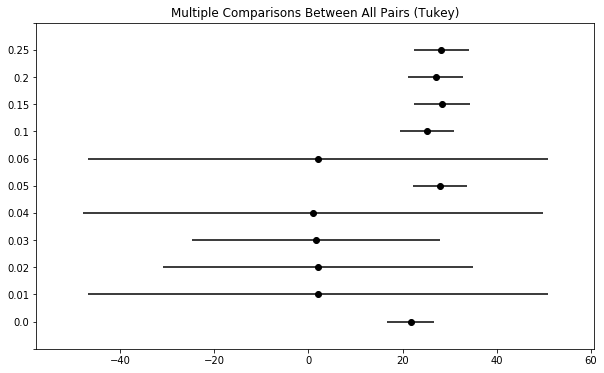

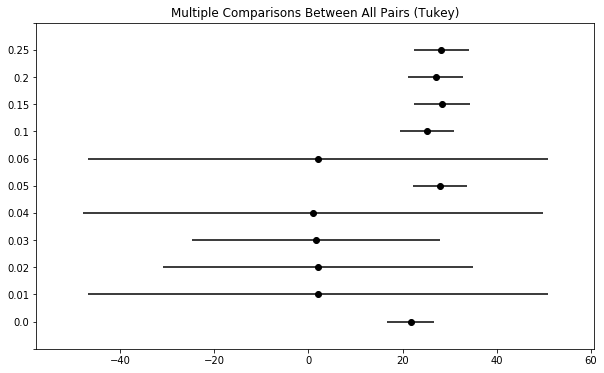

In [23]:
model.plot_simultaneous()

In [150]:
#note: we can also use ANOVA to see existence of impact

grps = df.groupby('discount').groups

for grp in grps:

    grps[grp] = df.groupby('discount').get_group(grp)['quantity']

stats.f_oneway(grps[0.0],grps[0.05],grps[0.15],grps[0.2],grps[0.25])

F_onewayResult(statistic=12.29667552917365, pvalue=7.051853171887499e-10)

In [151]:
#note that we still have to run tukey test to see which set or sets is/are different

interesting to note that the size of the discount doesn't seem to matter past 5%. strangely, 10% seems not to matter, but 15% and higher matters. 

In [37]:
cur.execute("""select distinct companyname from shipper""")
df_shipper = pd.DataFrame(cur.fetchall())
df_shipper

,0
0,Speedy Express
1,United Package
2,Federal Shipping


In [50]:
cur.execute("""select orderdate, requireddate, shippeddate, shipvia
               from 'order' o
               where shippeddate is not null
               and shippeddate > requireddate
               order by 4""")
df_ship_dates = pd.DataFrame(cur.fetchall(), columns = ['orderdate','requireddate','shippeddate','shipvia'])
df_ship_dates

,orderdate,requireddate,shippeddate,shipvia
0,2012-08-14,2012-09-11,2012-09-12,1
1,2012-09-19,2012-10-17,2012-10-23,1
2,2013-04-23,2013-05-07,2013-05-23,1
3,2013-07-11,2013-08-08,2013-08-12,1
4,2013-09-08,2013-10-06,2013-10-15,1
5,2013-11-03,2013-11-17,2013-12-05,1
6,2013-11-03,2013-12-01,2013-12-05,1
7,2013-12-31,2014-01-28,2014-01-30,1
8,2014-01-13,2014-01-27,2014-02-04,1
9,2014-03-05,2014-04-02,2014-04-08,1


In [54]:
cur.execute("""select distinct companyname, country from supplier""")
df_supplier_names = pd.DataFrame(cur.fetchall(), columns = ['companyname','country'])
df_supplier_names

,companyname,country
0,Exotic Liquids,UK
1,New Orleans Cajun Delights,USA
2,Grandma Kelly's Homestead,USA
3,Tokyo Traders,Japan
4,Cooperativa de Quesos 'Las Cabras',Spain
5,Mayumi's,Japan
6,"Pavlova, Ltd.",Australia
7,"Specialty Biscuits, Ltd.",UK
8,PB Knäckebröd AB,Sweden
9,Refrescos Americanas LTDA,Brazil


In [72]:
cur.execute("""select o.shipcountry, o.orderdate, sum(od.quantity) from 'order' o
               join orderdetail od
               on o.id = od.orderid
               group by 2""")
blerg = pd.DataFrame(cur.fetchall(), columns=['shipcountry','orderdate','quantity'])
blerg

,shipcountry,orderdate,quantity
0,France,2012-07-04,27
1,Germany,2012-07-05,49
2,Brazil,2012-07-08,101
3,Belgium,2012-07-09,105
4,Brazil,2012-07-10,102
...,...,...,...
475,Italy,2014-04-30,151
476,USA,2014-05-01,277
477,Germany,2014-05-04,101
478,Germany,2014-05-05,365


In [73]:
blerg['orderdate'] = pd.to_datetime(blerg['orderdate'], format='%Y/%m/%d')
blerg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 3 columns):
shipcountry    480 non-null object
orderdate      480 non-null datetime64[ns]
quantity       480 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 11.4+ KB


In [74]:
blerg['quarter'] = blerg['orderdate'].dt.to_period("q")
blerg['quarter'] = blerg.apply(lambda row: int(str(row['quarter'])[-1]), axis=1)
blerg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 4 columns):
shipcountry    480 non-null object
orderdate      480 non-null datetime64[ns]
quantity       480 non-null int64
quarter        480 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 15.1+ KB


In [75]:
blerg['hemisphere'] = blerg.apply(lambda row: "Southern" if row['shipcountry'] in ['Brazil','Argentina']
                                  else "Northern", axis=1)
blerg_northern = blerg[blerg['hemisphere'] == 'Northern']
blerg_southern = blerg[blerg['hemisphere'] == 'Southern']

<BarContainer object of 1 artists>

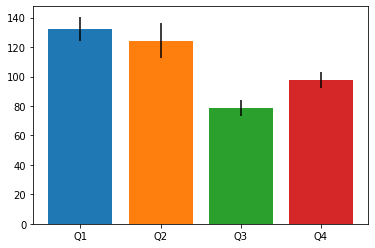

In [85]:
grp0 = blerg.groupby('quarter').get_group(1)['quantity']
grp1 = blerg.groupby('quarter').get_group(2)['quantity']
grp2 = blerg.groupby('quarter').get_group(3)['quantity']
grp3 = blerg.groupby('quarter').get_group(4)['quantity']

plt.bar(x='Q1', height=grp0.mean(), yerr=stats.sem(grp0))
plt.bar(x='Q2', height=grp1.mean(), yerr=stats.sem(grp1))
plt.bar(x='Q3', height=grp2.mean(), yerr=stats.sem(grp2))
plt.bar(x='Q4', height=grp3.mean(), yerr=stats.sem(grp3))

In [86]:
for grp in [grp0,grp1,grp2,grp3]:
    print(stats.normaltest(grp))

NormaltestResult(statistic=71.88070533047213, pvalue=2.462085666549949e-16)
NormaltestResult(statistic=63.04152441886395, pvalue=2.0450640156162815e-14)
NormaltestResult(statistic=48.25959334243682, pvalue=3.31560248332186e-11)
NormaltestResult(statistic=13.21563374774304, pvalue=0.0013497756657326514)


In [87]:
#sample sizes are large enough to still use anova

from scipy.stats import f_oneway

f_oneway(grp0,grp1,grp2,grp3)

F_onewayResult(statistic=10.936050410502693, pvalue=5.879748582008128e-07)

In [88]:
data = blerg['quantity'].values
labels = blerg['quarter'].values
model = sms.stats.multicomp.pairwise_tukeyhsd(data, labels)
model.summary()


group1,group2,meandiff,p-adj,lower,upper,reject
1,2,-8.1064,0.8837,-37.3175,21.1048,False
1,3,-53.6079,0.001,-80.1857,-27.03,True
1,4,-34.7625,0.0042,-61.1895,-8.3356,True
2,3,-45.5015,0.001,-74.6656,-16.3374,True
2,4,-26.6562,0.0849,-55.6829,2.3705,False
3,4,18.8453,0.255,-7.5296,45.2202,False


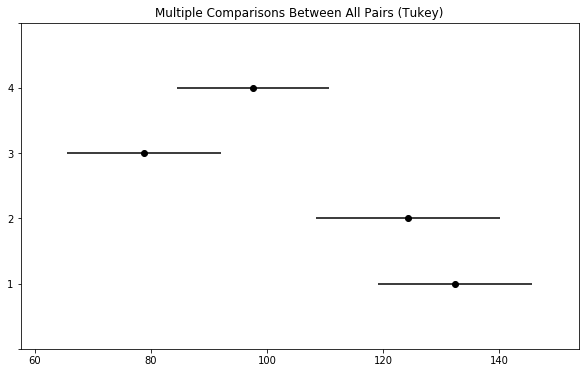

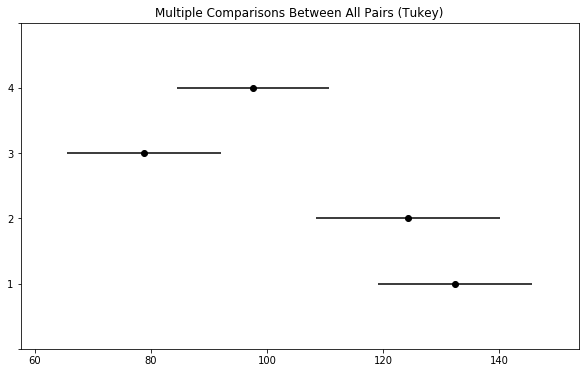

In [89]:
model.plot_simultaneous()

<BarContainer object of 1 artists>

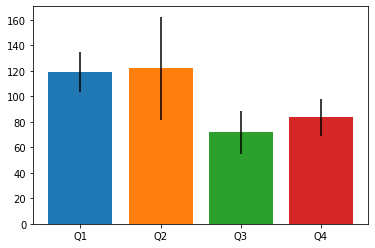

In [81]:
grp0 = blerg_southern.groupby('quarter').get_group(1)['quantity']
grp1 = blerg_southern.groupby('quarter').get_group(2)['quantity']
grp2 = blerg_southern.groupby('quarter').get_group(3)['quantity']
grp3 = blerg_southern.groupby('quarter').get_group(4)['quantity']

plt.bar(x='Q1', height=grp0.mean(), yerr=stats.sem(grp0))
plt.bar(x='Q2', height=grp1.mean(), yerr=stats.sem(grp1))
plt.bar(x='Q3', height=grp2.mean(), yerr=stats.sem(grp2))
plt.bar(x='Q4', height=grp3.mean(), yerr=stats.sem(grp3))

In [82]:
for grp in [grp0,grp1,grp2,grp3]:
    print(stats.normaltest(grp))

NormaltestResult(statistic=0.9857195599386055, pvalue=0.6108769202412472)


C:\Users\Devin\Anaconda3\envs\learn-env\lib\site-packages\scipy\stats\stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


ValueError: skewtest is not valid with less than 8 samples; 4 samples were given.

In [83]:
f_oneway(grp0,grp1,grp2,grp3)

F_onewayResult(statistic=1.869920079108597, pvalue=0.14897917233931673)

In [84]:
data = blerg['quantity'].values
labels = blerg['quarter'].values
model = sms.stats.multicomp.pairwise_tukeyhsd(data, labels)
model.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
1,2,-8.1064,0.8837,-37.3175,21.1048,False
1,3,-53.6079,0.001,-80.1857,-27.03,True
1,4,-34.7625,0.0042,-61.1895,-8.3356,True
2,3,-45.5015,0.001,-74.6656,-16.3374,True
2,4,-26.6562,0.0849,-55.6829,2.3705,False
3,4,18.8453,0.255,-7.5296,45.2202,False


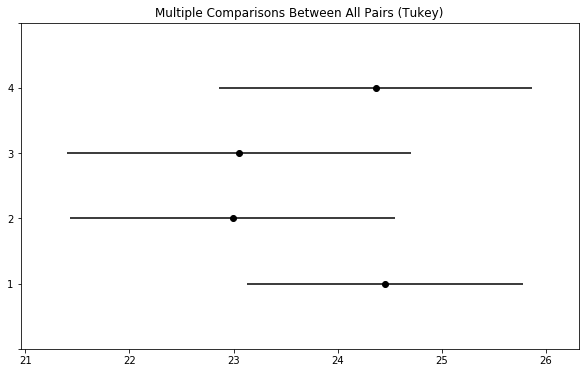

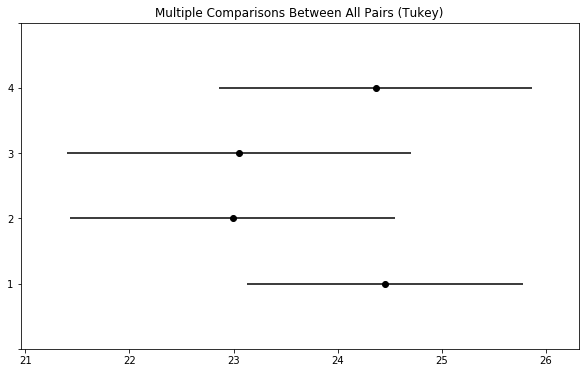

In [142]:
model.plot_simultaneous()

<BarContainer object of 1 artists>

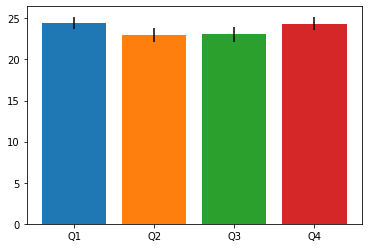

In [57]:
#without caring about hemisphere:

grp0 = blerg.groupby('quarter').get_group(1)['quantity']
grp1 = blerg.groupby('quarter').get_group(2)['quantity']
grp2 = blerg.groupby('quarter').get_group(3)['quantity']
grp3 = blerg.groupby('quarter').get_group(4)['quantity']

plt.bar(x='Q1', height=grp0.mean(), yerr=stats.sem(grp0))
plt.bar(x='Q2', height=grp1.mean(), yerr=stats.sem(grp1))
plt.bar(x='Q3', height=grp2.mean(), yerr=stats.sem(grp2))
plt.bar(x='Q4', height=grp3.mean(), yerr=stats.sem(grp3))

In [58]:
for grp in [grp0,grp1,grp2,grp3]:
    print(stats.normaltest(grp))

NormaltestResult(statistic=225.78272055697272, pvalue=9.373573227575504e-50)
NormaltestResult(statistic=196.14564215683524, pvalue=2.555730059276382e-43)
NormaltestResult(statistic=185.8715909158419, pvalue=4.3500761680111635e-41)
NormaltestResult(statistic=220.25812255860825, pvalue=1.4844186058916446e-48)


In [59]:
f_oneway(grp0,grp1,grp2,grp3)

F_onewayResult(statistic=0.9552656193269313, pvalue=0.41298296788057387)

In [143]:
cur.execute("""select * from 'order'""")
blaf = pd.DataFrame(cur.fetchall())
blaf
names = list(map(lambda x: x[0], cur.description))
cur.description

(('Id', None, None, None, None, None, None),
 ('CustomerId', None, None, None, None, None, None),
 ('EmployeeId', None, None, None, None, None, None),
 ('OrderDate', None, None, None, None, None, None),
 ('RequiredDate', None, None, None, None, None, None),
 ('ShippedDate', None, None, None, None, None, None),
 ('ShipVia', None, None, None, None, None, None),
 ('Freight', None, None, None, None, None, None),
 ('ShipName', None, None, None, None, None, None),
 ('ShipAddress', None, None, None, None, None, None),
 ('ShipCity', None, None, None, None, None, None),
 ('ShipRegion', None, None, None, None, None, None),
 ('ShipPostalCode', None, None, None, None, None, None),
 ('ShipCountry', None, None, None, None, None, None))

two hypotheses down. next we should test whether employee age groups have any impact on quantity in an order or revenue or whatever.

In [2]:
cur.execute("""select * from employee""")
emp = pd.DataFrame(cur.fetchall())
emp

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2024-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp
1,2,Fuller,Andrew,"Vice President, Sales",Dr.,1984-02-19,2024-08-14,908 W. Capital Way,Tacoma,North America,98401,USA,(206) 555-9482,3457,None,Andrew received his BTS commercial in 1974 and...,NaN,http://accweb/emmployees/fuller.bmp
2,3,Leverling,Janet,Sales Representative,Ms.,1995-08-30,2024-04-01,722 Moss Bay Blvd.,Kirkland,North America,98033,USA,(206) 555-3412,3355,None,Janet has a BS degree in chemistry from Boston...,2.0,http://accweb/emmployees/leverling.bmp
3,4,Peacock,Margaret,Sales Representative,Mrs.,1969-09-19,2025-05-03,4110 Old Redmond Rd.,Redmond,North America,98052,USA,(206) 555-8122,5176,None,Margaret holds a BA in English literature from...,2.0,http://accweb/emmployees/peacock.bmp
4,5,Buchanan,Steven,Sales Manager,Mr.,1987-03-04,2025-10-17,14 Garrett Hill,London,British Isles,SW1 8JR,UK,(71) 555-4848,3453,None,Steven Buchanan graduated from St. Andrews Uni...,2.0,http://accweb/emmployees/buchanan.bmp
5,6,Suyama,Michael,Sales Representative,Mr.,1995-07-02,2025-10-17,Coventry House Miner Rd.,London,British Isles,EC2 7JR,UK,(71) 555-7773,428,None,Michael is a graduate of Sussex University (MA...,5.0,http://accweb/emmployees/davolio.bmp
6,7,King,Robert,Sales Representative,Mr.,1992-05-29,2026-01-02,Edgeham Hollow Winchester Way,London,British Isles,RG1 9SP,UK,(71) 555-5598,465,None,Robert King served in the Peace Corps and trav...,5.0,http://accweb/emmployees/davolio.bmp
7,8,Callahan,Laura,Inside Sales Coordinator,Ms.,1990-01-09,2026-03-05,4726 - 11th Ave. N.E.,Seattle,North America,98105,USA,(206) 555-1189,2344,None,Laura received a BA in psychology from the Uni...,2.0,http://accweb/emmployees/davolio.bmp
8,9,Dodsworth,Anne,Sales Representative,Ms.,1998-01-27,2026-11-15,7 Houndstooth Rd.,London,British Isles,WG2 7LT,UK,(71) 555-4444,452,None,Anne has a BA degree in English from St. Lawre...,5.0,http://accweb/emmployees/davolio.bmp


In [3]:
cur.description

(('Id', None, None, None, None, None, None),
 ('LastName', None, None, None, None, None, None),
 ('FirstName', None, None, None, None, None, None),
 ('Title', None, None, None, None, None, None),
 ('TitleOfCourtesy', None, None, None, None, None, None),
 ('BirthDate', None, None, None, None, None, None),
 ('HireDate', None, None, None, None, None, None),
 ('Address', None, None, None, None, None, None),
 ('City', None, None, None, None, None, None),
 ('Region', None, None, None, None, None, None),
 ('PostalCode', None, None, None, None, None, None),
 ('Country', None, None, None, None, None, None),
 ('HomePhone', None, None, None, None, None, None),
 ('Extension', None, None, None, None, None, None),
 ('Photo', None, None, None, None, None, None),
 ('Notes', None, None, None, None, None, None),
 ('ReportsTo', None, None, None, None, None, None),
 ('PhotoPath', None, None, None, None, None, None))

why is every hire date in the future seriously what the fuck fuck this hypothesis

In [42]:
cur.execute("""select * from 'order'""")
orders = pd.DataFrame(cur.fetchall())
territory
cur.description

(('Id', None, None, None, None, None, None),
 ('CustomerId', None, None, None, None, None, None),
 ('EmployeeId', None, None, None, None, None, None),
 ('OrderDate', None, None, None, None, None, None),
 ('RequiredDate', None, None, None, None, None, None),
 ('ShippedDate', None, None, None, None, None, None),
 ('ShipVia', None, None, None, None, None, None),
 ('Freight', None, None, None, None, None, None),
 ('ShipName', None, None, None, None, None, None),
 ('ShipAddress', None, None, None, None, None, None),
 ('ShipCity', None, None, None, None, None, None),
 ('ShipRegion', None, None, None, None, None, None),
 ('ShipPostalCode', None, None, None, None, None, None),
 ('ShipCountry', None, None, None, None, None, None))

In [43]:
cur.execute("""select * from orderdetail""")
orderdetails = pd.DataFrame(cur.fetchall())
cur.description

(('Id', None, None, None, None, None, None),
 ('OrderId', None, None, None, None, None, None),
 ('ProductId', None, None, None, None, None, None),
 ('UnitPrice', None, None, None, None, None, None),
 ('Quantity', None, None, None, None, None, None),
 ('Discount', None, None, None, None, None, None))

In [5]:
cur.execute("""select distinct o.id, e.birthdate, od.unitprice, od.quantity
               from 'order' o
               join employee e on o.employeeid = e.id
               join orderdetail od on o.id = od.orderid
               order by 2""")
revenue_by_birthdate = pd.DataFrame(cur.fetchall(), columns=['Order ID','Birthdate','Unit Price','Quantity'])
revenue_by_birthdate

,Order ID,Birthdate,Unit Price,Quantity
0,10250,1969-09-19,7.7,10
1,10250,1969-09-19,42.4,35
2,10250,1969-09-19,16.8,15
3,10252,1969-09-19,64.8,40
4,10252,1969-09-19,2.0,25
...,...,...,...,...
2149,11022,1998-01-27,9.2,35
2150,11022,1998-01-27,36.0,30
2151,11058,1998-01-27,10.0,3
2152,11058,1998-01-27,34.0,21


In [6]:
revenue_by_birthdate['Total Revenue by item'] = revenue_by_birthdate.apply(lambda row: 
                                                                         row['Unit Price']*row['Quantity'], axis=1)
revenue_by_birthdate

,Order ID,Birthdate,Unit Price,Quantity,Total Revenue by item
0,10250,1969-09-19,7.7,10,77.0
1,10250,1969-09-19,42.4,35,1484.0
2,10250,1969-09-19,16.8,15,252.0
3,10252,1969-09-19,64.8,40,2592.0
4,10252,1969-09-19,2.0,25,50.0
...,...,...,...,...,...
2149,11022,1998-01-27,9.2,35,322.0
2150,11022,1998-01-27,36.0,30,1080.0
2151,11058,1998-01-27,10.0,3,30.0
2152,11058,1998-01-27,34.0,21,714.0


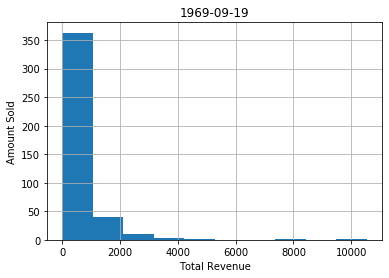

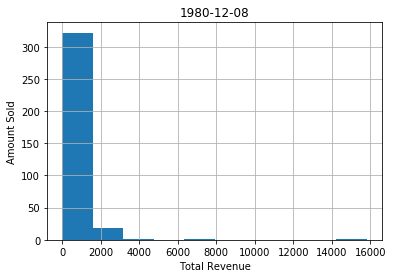

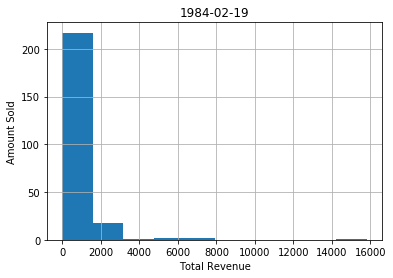

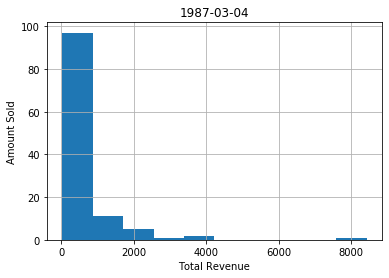

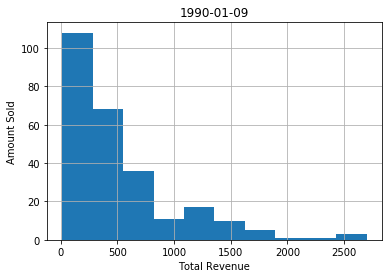

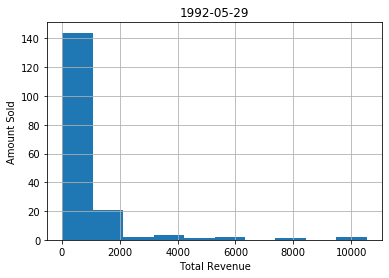

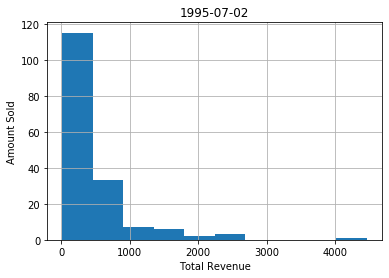

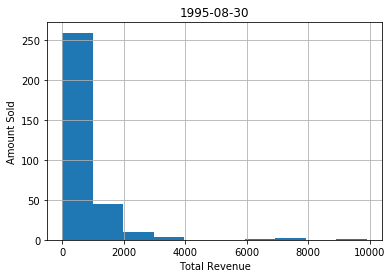

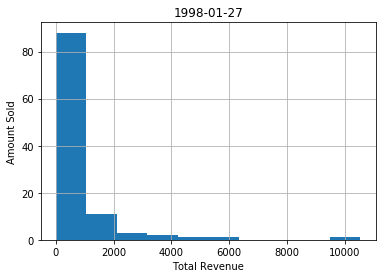

In [10]:
for date in revenue_by_birthdate['Birthdate'].unique():
    revenue_by_birthdate[revenue_by_birthdate['Birthdate'] == date].hist(column='Total Revenue by item')
    plt.title(date)
    plt.xlabel('Total Revenue')
    plt.ylabel('Amount Sold')

In [11]:
a = revenue_by_birthdate[revenue_by_birthdate['Birthdate'] == '1969-09-19']
a = a['Total Revenue by item']
b = revenue_by_birthdate[revenue_by_birthdate['Birthdate'] == '1980-12-08']
b = b['Total Revenue by item']
c = revenue_by_birthdate[revenue_by_birthdate['Birthdate'] == '1984-02-19']
c = c['Total Revenue by item']
d = revenue_by_birthdate[revenue_by_birthdate['Birthdate'] == '1987-03-04']
d = d['Total Revenue by item']
e = revenue_by_birthdate[revenue_by_birthdate['Birthdate'] == '1990-01-09']
e = e['Total Revenue by item']
f = revenue_by_birthdate[revenue_by_birthdate['Birthdate'] == '1992-05-29']
f = f['Total Revenue by item']
g = revenue_by_birthdate[revenue_by_birthdate['Birthdate'] == '1995-07-02']
g = g['Total Revenue by item']
h = revenue_by_birthdate[revenue_by_birthdate['Birthdate'] == '1995-08-30']
h = h['Total Revenue by item']
i = revenue_by_birthdate[revenue_by_birthdate['Birthdate'] == '1998-01-27']
i = i['Total Revenue by item']

In [12]:
#anova test
from scipy.stats import f_oneway

f_oneway(a,b,c,d,e,f,g,h,i)

F_onewayResult(statistic=2.338260793953131, pvalue=0.016841677258803325)

In [14]:
from scipy.stats import kruskal

kruskal(a,b,c,d,e,f,g,h,i)

KruskalResult(statistic=10.766600688693485, pvalue=0.2152778357561379)

we used kruskal because we can't assume normal, independent, homoskedastic distributions, and therefore a non-parametric median-based test was more appropriate. 

In [95]:
cur.execute("""select distinct o.id, e.country, avg(od.discount)
               from 'order' o
               join employee e on e.id = o.employeeid
               join orderdetail od on od.orderid = o.id
               group by 1""")
count_by_country = pd.DataFrame(cur.fetchall(), columns=['orderID','country of sales rep','average discount in order'])
count_by_country

,orderID,country of sales rep,average discount in order
0,10248,UK,0.000000
1,10249,UK,0.000000
2,10250,USA,0.100000
3,10251,USA,0.033333
4,10252,USA,0.033333
...,...,...,...
825,11073,USA,0.000000
826,11074,UK,0.050000
827,11075,USA,0.150000
828,11076,USA,0.250000


In [96]:
grp0 = count_by_country.groupby('country of sales rep').get_group('UK')['average discount in order']
grp1 = count_by_country.groupby('country of sales rep').get_group('USA')['average discount in order']

<BarContainer object of 1 artists>

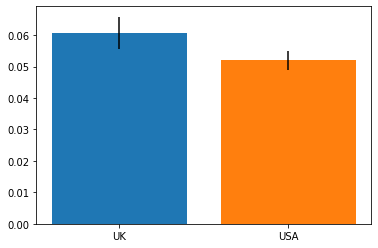

In [97]:
plt.bar(x='UK', height=grp0.mean(), yerr=stats.sem(grp0))

plt.bar(x='USA', height=grp1.mean(), yerr=stats.sem(grp1))

In [98]:
stats.normaltest(grp0), stats.normaltest(grp1)

(NormaltestResult(statistic=29.21057587088821, pvalue=4.5394584260173466e-07),
 NormaltestResult(statistic=114.84021802148685, pvalue=1.155482856407473e-25))

In [101]:
stats.mannwhitneyu(grp0, grp1)

MannwhitneyuResult(statistic=63004.0, pvalue=0.04162526382786643)

In [102]:
cur.execute("""select max(orderdate), min(orderdate)
               from 'order'""")
lkjsdf = pd.DataFrame(cur.fetchall())
lkjsdf

,0,1
0,2014-05-06,2012-07-04
